## Topography filtering 

We don't really want to filter topography, as a coarse model is sort of a sub-sampled topography rather than filtered. 

Here we see if this impacts the thickness fluxes. 

> Since the bottom is flat, we should expect no difference between the 2 approaches. 

#### Setup dask

When doing filtering, it may be useful to use many processes as it is very slow but easily parallelizable. 

In [1]:
I_want_dask = False

if I_want_dask: 
    from dask_gateway import Gateway
    gateway = Gateway()
    
    # close existing clusters
    open_clusters = gateway.list_clusters()
    print(list(open_clusters))
    
    flag_shut = False 
    
    if flag_shut: 
        if len(open_clusters)>0:
            for c in open_clusters:
                cluster = gateway.connect(c.name)
                cluster.shutdown()  
    
    options = gateway.cluster_options()
    
    #options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
    # options.worker_cores = 8
    
    options.environment = dict(
        DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
    )
    
    # Create a cluster with those options
    cluster = gateway.new_cluster(options)
    client = cluster.get_client()
    cluster.adapt(15, 40)
    #cluster.scale(10)
    client

### Start

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [4]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr')

### Model state

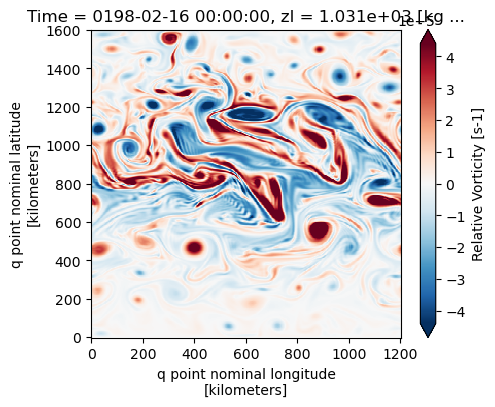

In [5]:
plt.figure(figsize=(5,4))
ds.RV.isel(Time=-1, zl=0).plot(robust=True)

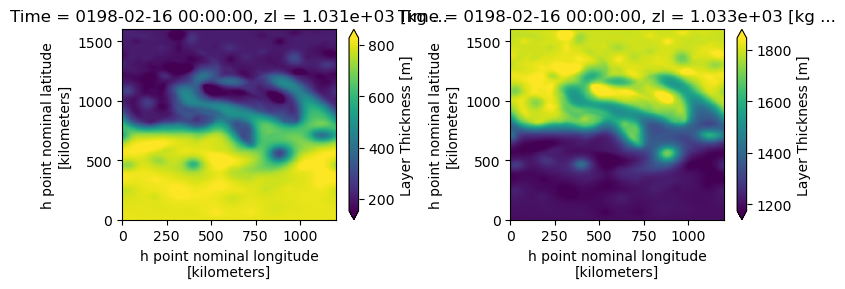

In [6]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds.h.isel(Time=-1, zl=0).plot(robust=True)

plt.subplot(122)
ds.h.isel(Time=-1, zl=1).plot(robust=True)

plt.tight_layout()

Text(0.5, 1.0, 'Thicknesses')

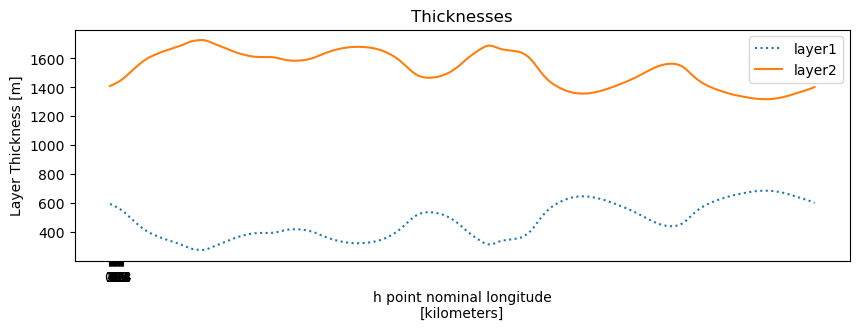

In [7]:
plt.figure(figsize=(10,3))
ds.h.isel(Time=-1, zl=0).sel(yh=800, method='nearest').plot(linestyle=':',label='layer1')
ds.h.isel(Time=-1, zl=1).sel(yh=800, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses')

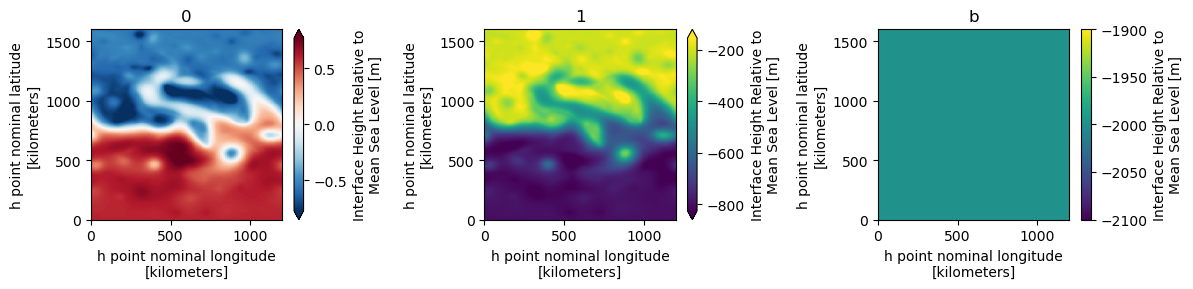

In [8]:
plt.figure(figsize=(12,3))

plt.subplot(131)
ds.e.isel(Time=-1, zi=0).plot(robust=True)
plt.title('0')

plt.subplot(132)
ds.e.isel(Time=-1, zi=1).plot(robust=True)
plt.title('1')

plt.subplot(133)
ds.e.isel(Time=-1, zi=2).plot(robust=True)
plt.title('b')

plt.tight_layout()

Text(0.5, 1.0, 'interfaces')

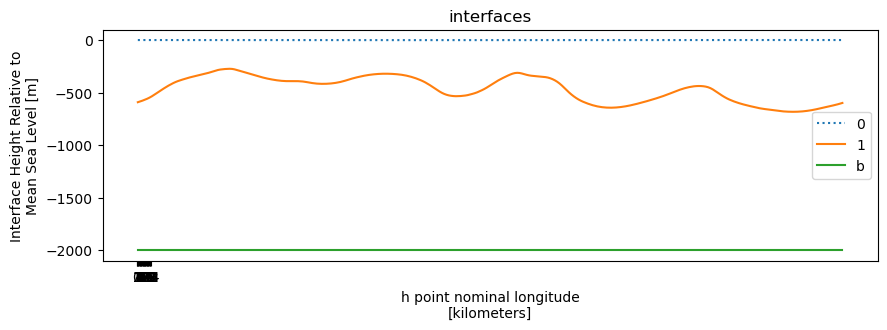

In [9]:
plt.figure(figsize=(10,3))
ds.e.isel(Time=-1, zi=0).sel(yh=800, method='nearest').plot(linestyle=':',label='0')
ds.e.isel(Time=-1, zi=1).sel(yh=800, method='nearest').plot(label='1')
ds.e.isel(Time=-1, zi=2).sel(yh=800, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

Text(0.5, 1.0, 'interfaces')

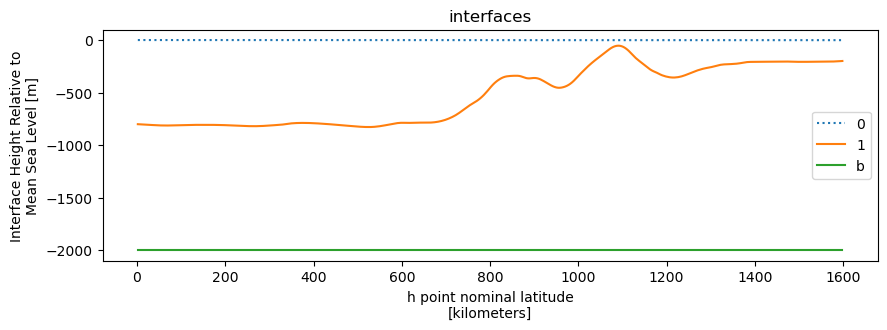

In [10]:
plt.figure(figsize=(10,3))
ds.e.isel(Time=-1, zi=0).sel(xh=500, method='nearest').plot(linestyle=':',label='0')
ds.e.isel(Time=-1, zi=1).sel(xh=500, method='nearest').plot(label='1')
ds.e.isel(Time=-1, zi=2).sel(xh=500, method='nearest').plot(label='b')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

### Filtering

In [9]:
#ds = ds.isel(Time=slice(-3,-1))

In [11]:
Lfilter = 100e3
dx = 4e3

In [12]:
#wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
wet_mask= (ds.h.isel(Time=0, zl=1)>1).astype('float32').rename('wet_mask')
# Changning this wet mask changes things a little bit. 

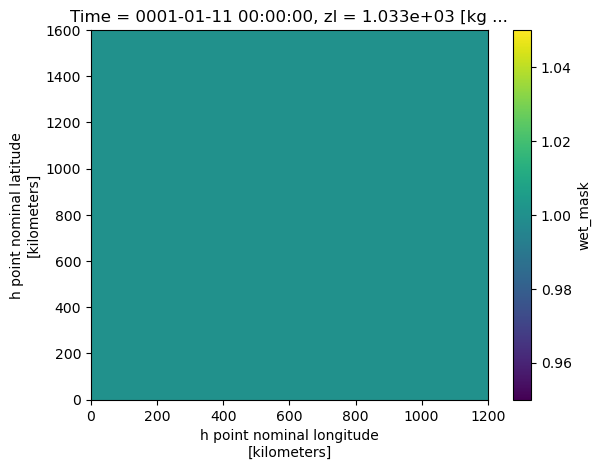

In [13]:
wet_mask.plot()

In [14]:
filter_C = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     grid_vars = {'wet_mask': wet_mask})

In [15]:
xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

In [16]:
ds_filt = xr.Dataset() 
ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
ds_filt['e'] = filter_C.apply(ds.e, dims=['yh','xh']).rename('e')

In [17]:
ds_filt

<xarray.Dataset>
Dimensions:  (Time: 7200, xh: 300, yh: 400, zl: 2, zi: 3)
Coordinates:
  * Time     (Time) object 0001-01-11 00:00:00 ... 0198-02-16 00:00:00
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.19e+03 1.194e+03 1.198e+03
  * yh       (yh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * zl       (zl) float64 1.031e+03 1.033e+03
  * zi       (zi) float64 1.03e+03 1.032e+03 1.034e+03
Data variables:
    h        (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 400, 300), meta=np.ndarray>
    e        (Time, zi, yh, xh) float32 dask.array<chunksize=(72, 3, 400, 300), meta=np.ndarray>

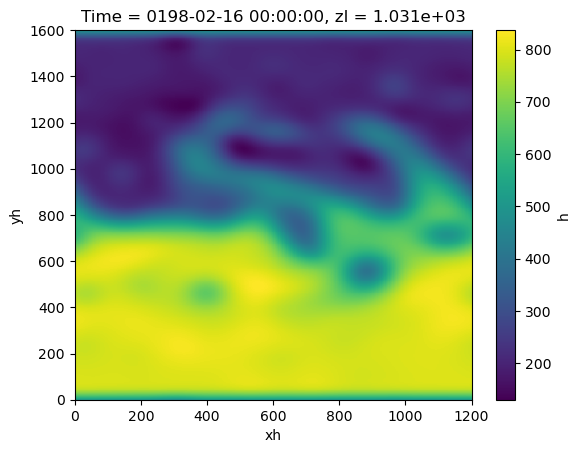

In [18]:
ds_filt.h.isel(Time=-1, zl=0).plot()

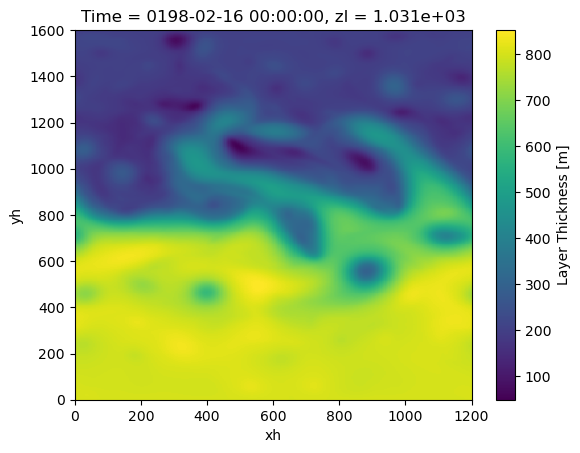

In [19]:
ds.h.isel(Time=-1, zl=0).plot()

In [17]:
#ds_filt.load();

In [18]:
ds_anom = ds - ds_filt

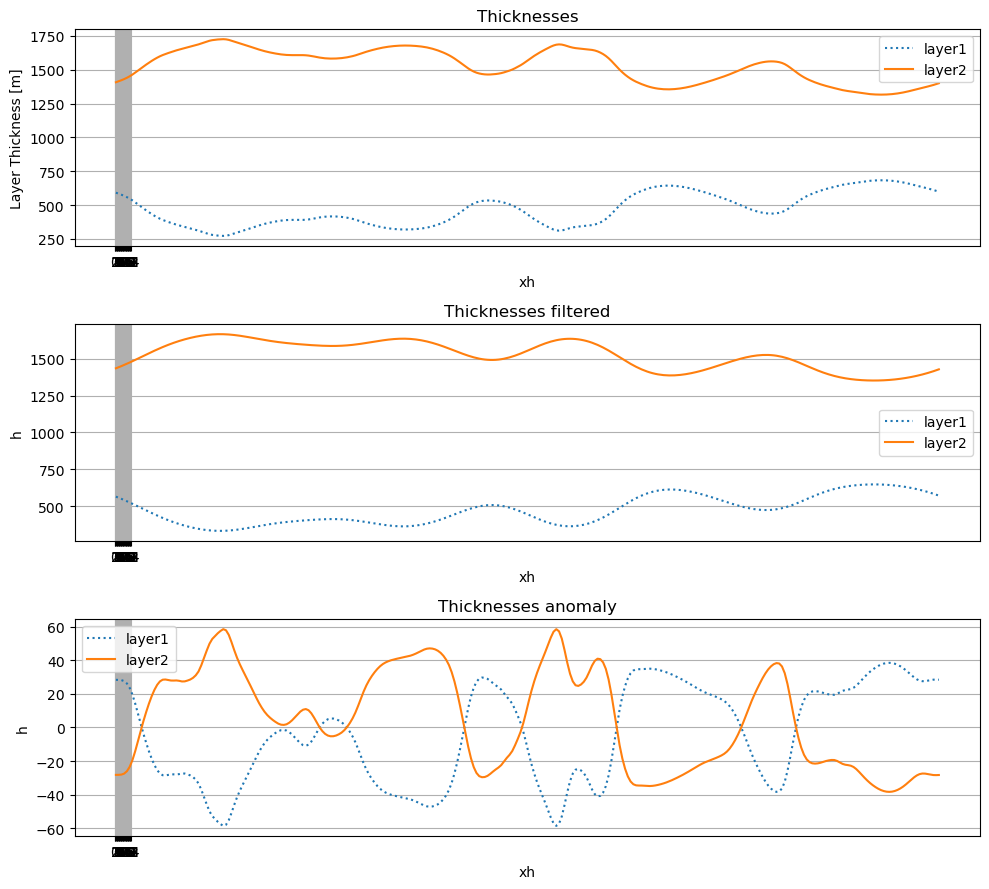

In [20]:
plt.figure(figsize=(10,9))

plt.subplot(311)
ds.h.isel(Time=-1, zl=0).sel(yh=800, method='nearest').plot(linestyle=':',label='layer1')
ds.h.isel(Time=-1, zl=1).sel(yh=800, method='nearest').plot(label='layer2')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses')
plt.grid()

plt.subplot(312)
ds_filt.h.isel(Time=-1, zl=0).sel(yh=800, method='nearest').plot(linestyle=':',label='layer1')
ds_filt.h.isel(Time=-1, zl=1).sel(yh=800, method='nearest').plot(label='layer2')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses filtered')
plt.grid()

plt.subplot(313)
ds_anom.h.isel(Time=-1, zl=0).sel(yh=800, method='nearest').plot(linestyle=':',label='layer1')
ds_anom.h.isel(Time=-1, zl=1).sel(yh=800, method='nearest').plot(label='layer2')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses anomaly')
plt.grid()

plt.tight_layout()

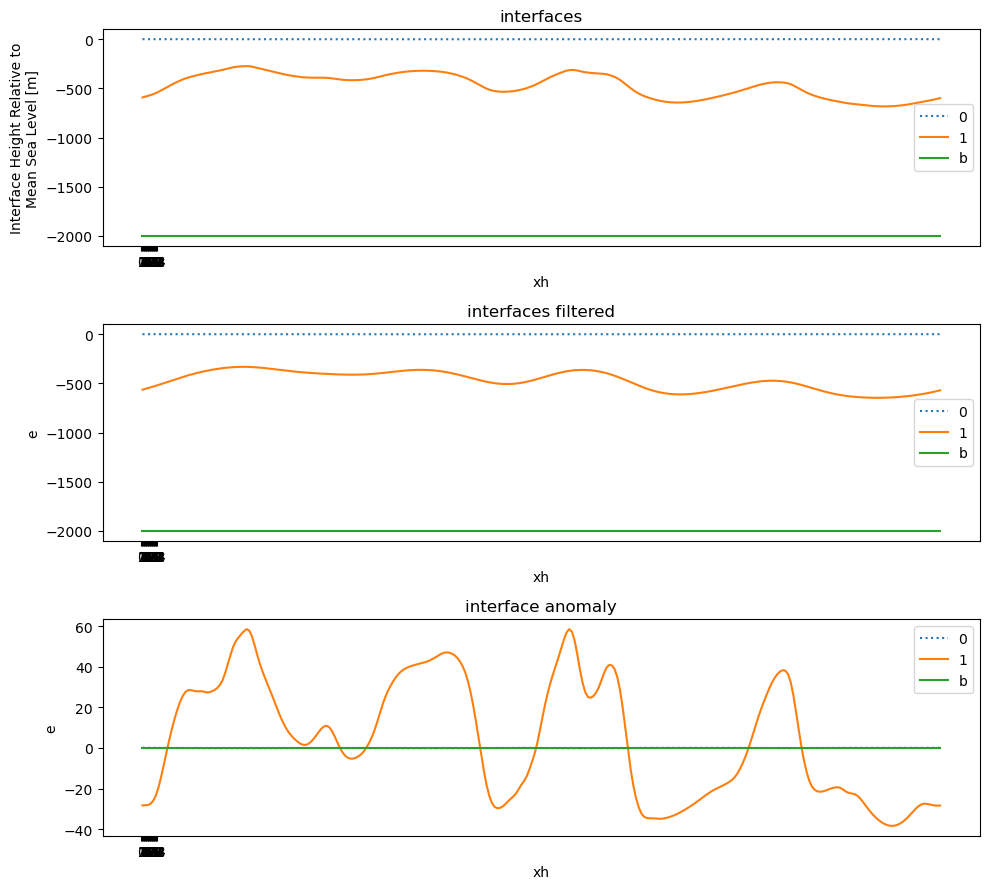

In [21]:
plt.figure(figsize=(10,9))

plt.subplot(311)
ds.e.isel(Time=-1, zi=0).sel(yh=800, method='nearest').plot(linestyle=':',label='0')
ds.e.isel(Time=-1, zi=1).sel(yh=800, method='nearest').plot(label='1')
ds.e.isel(Time=-1, zi=2).sel(yh=800, method='nearest').plot(label='b')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

plt.subplot(312)
ds_filt.e.isel(Time=-1, zi=0).sel(yh=800, method='nearest').plot(linestyle=':',label='0')
ds_filt.e.isel(Time=-1, zi=1).sel(yh=800, method='nearest').plot(label='1')
ds_filt.e.isel(Time=-1, zi=2).sel(yh=800, method='nearest').plot(label='b')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('interfaces filtered')

plt.subplot(313)
ds_anom.e.isel(Time=-1, zi=0).sel(yh=800, method='nearest').plot(linestyle=':',label='0')
ds_anom.e.isel(Time=-1, zi=1).sel(yh=800, method='nearest').plot(label='1')
ds_anom.e.isel(Time=-1, zi=2).sel(yh=800, method='nearest').plot(label='b')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('interface anomaly')

plt.tight_layout()

note that there are 2 things going on above to do with topography. 
1. There is the boundary issue, where the filter passes through the boundary, which creates a spike.
2. Also the filtered bottom interface is always a bit below the unfiltered (concave shape), which add a sign definite bias. [Except in region with flat bottom].

Does any of this impact the fluxes? 

In [22]:
v_c = xgrid.interp(ds.v.fillna(0), 'Y')
ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')

In [23]:
## Thickness method <uh> - <u><h>
ds_filt['vh'] = ds.h*v_c
ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']

In [24]:
## Interface method 
ds_filt['v2e1'] = ds.e.isel(zi=1)*v_c.isel(zl=1)
ds_filt['v2e1_bar'] = filter_C.apply(ds_filt['v2e1'], dims=['yh','xh']).rename('v2e1_bar')
ds_filt['v2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.v.isel(zl=1))
ds_filt['v2e1_sg'] = ds_filt['v2e1_bar'] - ds_filt['v2bar_e1bar']


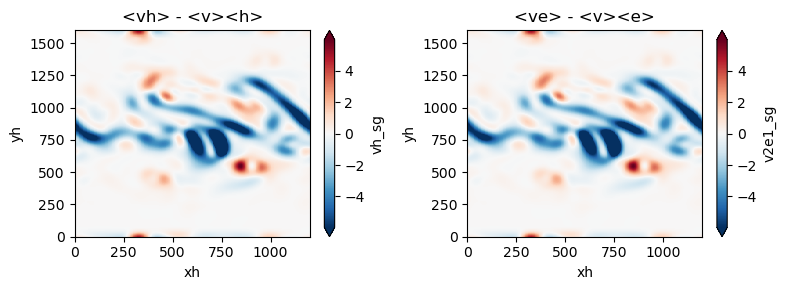

In [25]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['vh_sg'].isel(zl=-1, Time=-1).plot(robust=True)
plt.title('<vh> - <v><h>')

plt.subplot(122)
ds_filt['v2e1_sg'].isel( Time=-1).plot(robust=True)
plt.title('<ve> - <v><e>')

plt.tight_layout()

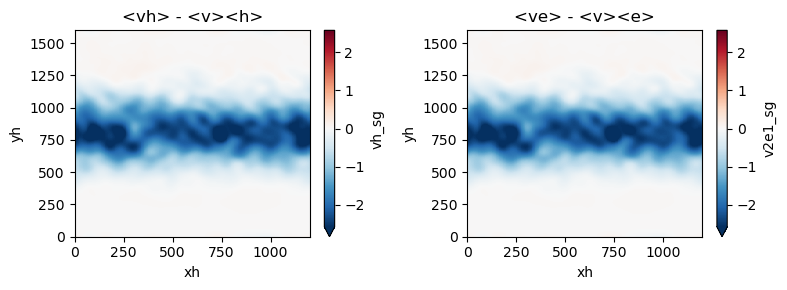

In [26]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['vh_sg'].isel(zl=-1, Time=slice(-100,-1)).mean('Time').plot(robust=True)
plt.title('<vh> - <v><h>')

plt.subplot(122)
ds_filt['v2e1_sg'].isel(Time=slice(-100,-1)).mean('Time').plot(robust=True)
plt.title('<ve> - <v><e>')

plt.tight_layout()

## When done

In [64]:
cluster.shutdown()